## Update
-Add Batch Normalization layer after each conv
-Add shuffle=True in model.fit() method for a better BN effect (so that we have different batch to normalize in each epoch during the training)
-You can use crf method (https://www.kaggle.com/meaninglesslives/apply-crf) to improve the result 
## Changelog
- Changed uncov to uconv, but removed the dropout in the last layer
- Corrected sanity check of predicted validation data (changed from ids_train to ids_valid)
- Used correct mask (from original train_df) for threshold tuning (inserted y_valid_ori)
- Added DICE loss functions

# About
Since I am new to learning from image segmentation and kaggle in general I want to share my noteook.
I saw it is similar to others as it uses the U-net approach. I want to share it anyway because:

- As said, the field is new to me so I am open to suggestions.
- It visualizes some of the steps, e.g. scaling, to learn if the methods do what I expect which might be useful to others (I call them sanity checks).
- Added stratification by the amount of salt contained in the image.
- Added augmentation by flipping the images along the y axes (thanks to the forum for clarification).
- Added dropout to the model which seems to improve performance.

In [41]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf
import sys
sys.path.append('../keras-deeplab-v3-plus')
from model import Deeplabv3
import glob

# Params and helpers

In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    return resize(img, (101, 101,3), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [4]:
ROOT = "/home/alexanderliao/data/Kaggle/datasets/pascal-voc-2012/VOC2012"
IMG_LIST = glob.glob(ROOT+'/SegmentationClass/*.png')
for i in range(len(IMG_LIST)):
    IMG_LIST[i]=IMG_LIST[i][83:len(IMG_LIST[i])-4]
    
from PIL import Image

def make_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, ( int((size-x)/2), int((size-y))))
    return new_im
IMG_LIST[1]

'2009_000080'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'\nfor i in range(500):\n    if not(  ( a[i][300]==np.array([0,0,0]) ).any() ):\n        print(a[i][300])\n        print(i)\n        break\n'

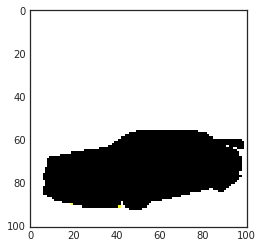

In [5]:
tvmonitor = np.array([0,64,-128])
ambiguous=np.array([-32,-32,-64])
train=np.array([-128,-64,0])
aeroplane=np.array([-128,0,0])
boat=np.array([  0   ,0,-128])
chair=np.array([-64 ,0 ,0])
dog=np.array([  64  ,0,-128])
bird=np.array([-128,-128,0])
diningtable=np.array([-64,-128 ,0])
bottle=np.array([-128   ,0,-128])
bicycle=np.array([   0,-128,0])
person=np.array([ -64 -128 -128])
motorbike=np.array([  64,-128,-128])
sheep=np.array([-128,64 ,0])
horse=np.array([ -64,0,-128])
cat=np.array([64,0 ,0])
bus=np.array([   0,-128,-128])
cow = np.array([  64,-128,0])
pottedplant=np.array([[ 0,64,0]])
sofa=np.array([  0,-64,  0])
background=np.array([0,0,0])
car=np.array([-128,-128,-128])

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
a=np.array(downsample(np.array(make_square(Image.open(ROOT+"/SegmentationClass/{}.png".format("2007_003143"))),dtype='int8')),dtype='int8')
imgplot = plt.imshow(a)
k=0
#for i in range(101):
#    print(a[70][i])



"""
for i in range(500):
    if not(  ( a[i][300]==np.array([0,0,0]) ).any() ):
        print(a[i][300])
        print(i)
        break
"""

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [6]:
train_images = [downsample(np.array(make_square(Image.open(ROOT+"/JPEGImages/{}.jpg".format(idx))))) / 255 for idx in tqdm_notebook(IMG_LIST)]
#train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [ ]:
train_masks = [np.array(downsample(np.array(make_square(Image.open(ROOT+"/SegmentationClass/{}.png".format(idx))),dtype='int8')),dtype='int8') for idx in tqdm_notebook(IMG_LIST)]
#train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [ ]:
from tqdm import tqdm
int_masks = []
for i in tqdm(range(len(train_masks))):
    image=train_masks[i]
    new_im=np.zeros((101,101,1))
    for i in range(101):
        for j in range(101):
            if (image[i,j,:] == aeroplane).all():
                new_im[i,j,:]=1
            elif (image[i,j,:] == bicycle).all():
                new_im[i,j,:]=2
            elif (image[i,j,:] == bird).all():
                new_im[i,j,:]=3
            elif (image[i,j,:] == boat).all():
                new_im[i,j,:]=4
            elif (image[i,j,:] == bottle).all():
                new_im[i,j,:]=5
            elif (image[i,j,:] == bus).all():
                new_im[i,j,:]=6
            elif (image[i,j,:] == car).all():
                new_im[i,j,:]=7
            elif (image[i,j,:] == cat).all():
                new_im[i,j,:]=8
            elif (image[i,j,:] == chair).all():
                new_im[i,j,:]=9
            elif (image[i,j,:] == cow).all():
                new_im[i,j,:]=10
            elif (image[i,j,:] == diningtable).all():
                new_im[i,j,:]=11
            elif (image[i,j,:] == dog).all():
                new_im[i,j,:]=12
            elif (image[i,j,:] == horse).all():
                new_im[i,j,:]=13
            elif (image[i,j,:] == motorbike).all():
                new_im[i,j,:]=14
            elif (image[i,j,:] == person).all():
                new_im[i,j,:]=15
            elif (image[i,j,:] == pottedplant).all():
                new_im[i,j,:]=16
            elif (image[i,j,:] == sheep).all():
                new_im[i,j,:]=17
            elif (image[i,j,:] == sofa).all():
                new_im[i,j,:]=18
            elif (image[i,j,:] == train).all():
                new_im[i,j,:]=19
            elif (image[i,j,:] == tvmonitor).all():
                new_im[i,j,:]=20
            elif (image[i,j,:] == ambiguous).all():
                new_im[i,j,:]=21
    int_masks.append(new_im)
                
                
                
            

In [7]:
import pickle
int_masks = pickle.load( open( "PASCAL_VOC2012_int_mask.p", "rb" ) )
#pickle.dump( int_masks, open( "PASCAL_VOC2012_int_mask.p", "wb" ) )

In [8]:
del train_masks

NameError: name 'train_masks' is not defined

In [ ]:
from keras.utils.np_utils import to_categorical
one_hot_masks = to_categorical(int_masks, num_classes=22)

In [ ]:
del int_masks

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [ ]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [ ]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

In [ ]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

# Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

In [ ]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Show some example images

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [9]:
 x_train, x_valid, y_train, y_valid = train_test_split(
    np.array(train_images).reshape(-1, img_size_target, img_size_target, 3), 
    np.array(int_masks).reshape(-1, img_size_target, img_size_target, 1), 
    test_size=0.2, random_state=1337)

In [10]:
del int_masks

In [ ]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Build model

In [ ]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [31]:
#model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)
del model
model =  Deeplabv3(input_shape=(101,101,3),backbone="mobilenetv2", classes=22)  

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy","sparse_categorical_crossentropy"])

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 101, 101, 3)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 51, 51, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 51, 51, 32)   128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 51, 51, 32)   0           Conv_BN[0][0]                    
__________________________________________________________________________________________________
expanded_c

# Data augmentation

In [14]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
#train_images=np.array(train_images)
#one_hot_masks=np.array(one_hot_masks)

In [ ]:
train_images.shape
#one_hot_masks.shape

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

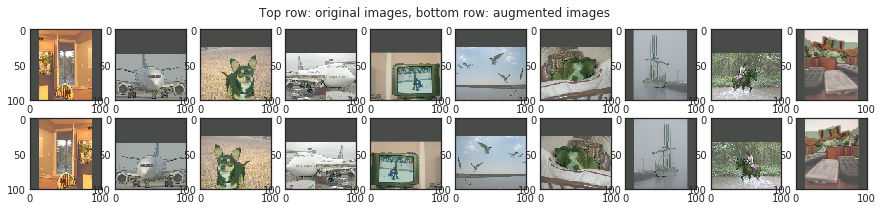

In [34]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [ ]:
print(x_train.shape)
print(np.repeat(x_train,3,3).shape)

In [35]:
early_stopping = EarlyStopping(patience=50, verbose=1)
model_checkpoint = ModelCheckpoint("./deeplabv3.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32
"""
with tf.device ("/gpu:0"):
    history = model.fit(train_images[0:5400,:,:,:], one_hot_masks[0:2700,:,:,:],
                        validation_data=[train_images[2701:2913,:,:,:], one_hot_masks[2701:2913,:,:,:]], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)
"""
with tf.device ("/gpu:0"):
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, model_checkpoint],shuffle=True)

Train on 4660 samples, validate on 583 samples
Epoch 1/200
4660/4660 [==============================] - 173s 37ms/step - loss: 2.9019 - acc: 0.7553 - sparse_categorical_crossentropy: 2.9019 - val_loss: 3.1731 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 3.1731

Epoch 00001: val_loss improved from inf to 3.17314, saving model to ./deeplabv3.model
Epoch 2/200
4660/4660 [==============================] - 155s 33ms/step - loss: 2.3826 - acc: 0.7827 - sparse_categorical_crossentropy: 2.3826 - val_loss: 2.8682 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 2.8682

Epoch 00002: val_loss improved from 3.17314 to 2.86823, saving model to ./deeplabv3.model
Epoch 3/200
4660/4660 [==============================] - 156s 34ms/step - loss: 2.2368 - acc: 0.7310 - sparse_categorical_crossentropy: 2.2368 - val_loss: 3.1598 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 3.1598

Epoch 00003: val_loss did not improve from 2.86823
Epoch 4/200
4660/4660 [======================

4660/4660 [==============================] - 157s 34ms/step - loss: 1.0708 - acc: 0.7953 - sparse_categorical_crossentropy: 1.0708 - val_loss: 2.8678 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 2.8678

Epoch 00029: val_loss did not improve from 2.35353
Epoch 30/200
4660/4660 [==============================] - 157s 34ms/step - loss: 1.0380 - acc: 0.8027 - sparse_categorical_crossentropy: 1.0380 - val_loss: 2.8760 - val_acc: 0.8219 - val_sparse_categorical_crossentropy: 2.8760

Epoch 00030: val_loss did not improve from 2.35353
Epoch 31/200
4660/4660 [==============================] - 157s 34ms/step - loss: 1.0056 - acc: 0.8075 - sparse_categorical_crossentropy: 1.0056 - val_loss: 2.8913 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 2.8913

Epoch 00031: val_loss did not improve from 2.35353
Epoch 32/200
4660/4660 [==============================] - 157s 34ms/step - loss: 1.0071 - acc: 0.8086 - sparse_categorical_crossentropy: 1.0071 - val_loss: 2.8684 - val_acc: 0.


Epoch 00057: val_loss did not improve from 1.28932
Epoch 58/200
4660/4660 [==============================] - 157s 34ms/step - loss: 0.8632 - acc: 0.8246 - sparse_categorical_crossentropy: 0.8632 - val_loss: 1.5606 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 1.5606

Epoch 00058: val_loss did not improve from 1.28932
Epoch 59/200
4660/4660 [==============================] - 157s 34ms/step - loss: 0.8632 - acc: 0.8246 - sparse_categorical_crossentropy: 0.8632 - val_loss: 1.3969 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 1.3969

Epoch 00059: val_loss did not improve from 1.28932
Epoch 60/200
4660/4660 [==============================] - 157s 34ms/step - loss: 0.8662 - acc: 0.8246 - sparse_categorical_crossentropy: 0.8662 - val_loss: 1.4791 - val_acc: 0.8220 - val_sparse_categorical_crossentropy: 1.4791

Epoch 00060: val_loss did not improve from 1.28932
Epoch 61/200
4660/4660 [==============================] - 157s 34ms/step - loss: 0.8605 - acc: 0.8246 - sparse_

KeyboardInterrupt: 

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [ ]:
model.load_weights("./deeplabv3.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [ ]:
preds_valid = model.predict(np.repeat(x_valid,3,3)).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [ ]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

In [ ]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Submission
Load, predict and submit the test image predictions.

In [ ]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [ ]:
x_test = np.array([upsample(np.array(load_img(ROOT+"/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
preds_test = model.predict(np.repeat(x_test,3,3))

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')